### Metrics calculation and some plots
Use this notebook to calculate the BWT and FWT scores for the images the network. This works for the registration predictions as well as U-Net predictions. Just set the paths to the networks predictions correctly and the notebook will do the rest.

#### Set paths

In [1]:
sam_exps = '/media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/Seq'
# sam_exps = '/media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/frozen_after_first_task'
# reh_exps =   '/media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/Reh'
# ewc_exps =   '/media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/EWC'
ewc_exps = '/media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/EWC_frozen_after_first_task'
rwalk_exps = '/media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/RWalk'

#### Import necessary libraries

In [2]:
from math import pi
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os, copy, monai, torch
from tqdm.notebook import trange, tqdm

/home/aranem_locale/anaconda3/envs/midl_2024/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Helpful functions and other stuffs

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

### SAM results

In [5]:
models = [x for x in os.listdir(sam_exps) if 'sam_adapter' in x]

models.sort()
dices_s = dict()
for model in models:
    dices_s[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3', '').replace('sam_adapter_', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(sam_exps, model)) if 'inference' in x]

    for pred in preds_:
        preds = os.path.join(sam_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_s[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_s[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_s[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_s[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_s[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_s[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/Seq/sam_adapter_97_100_lr-1e-4-with-adapter-lr-1e-3/inference..
Dice for model sam_adapter_97_100_lr-1e-4-with-adapter-lr-1e-3:
Task97_DecathHip: Mean dice +/- std: 87.7 (3.86)
Task98_Dryad: Mean dice +/- std: 27.47 (5.97)
Task99_HarP: Mean dice +/- std: 52.63 (20.6)

Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/Seq/sam_adapter_98_100_lr-1e-4-with-adapter-lr-1e-3/inference..
Dice for model sam_adapter_98_100_lr-1e-4-with-adapter-lr-1e-3:
Task97_DecathHip: Mean dice +/- std: 10.75 (6.73)
Task98_Dryad: Mean dice +/- std: 88.05 (1.32)
Task99_HarP: Mean dice +/- std: 18.62 (22.13)

Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/Seq/sam_adapter_99_100_lr-1e-4-with-adapter-lr-1e-3/inference..
Dice for model sam_adapter_99_100_lr-1e-4-with-adapter-lr-1e-3:
Task97_DecathHip: Mean dice +/- std: 61.16 (7.24)
Task98_Dryad: Mean dice +/- st

In [5]:
# Rehearsal
models = [x for x in os.listdir(reh_exps) if 'sam_adapter' in x and 'joint' not in x]

models.sort()
dices_reh = dict()
for model in models:
    dices_reh[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_reh', '').replace('sam_adapter_', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(reh_exps, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(reh_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_reh[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_reh', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_reh[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_reh', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_reh[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_reh', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_reh[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_reh', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_reh[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_reh', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_reh[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_reh', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

NameError: name 'reh_exps' is not defined

In [4]:
# EWC
models = [x for x in os.listdir(ewc_exps) if 'sam_adapter' in x and 'joint' not in x]

models.sort()
dices_ewc = dict()
for model in models:
    dices_ewc[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_ewc', '').replace('sam_adapter_', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(ewc_exps, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(ewc_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_ewc[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_ewc', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_ewc[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_ewc', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_ewc[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_ewc', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_ewc[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_ewc', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_ewc[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_ewc', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_ewc[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_ewc', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/EWC_frozen_after_first_task/sam_adapter_97_100_lr-1e-4-with-adapter-lr-1e-3_ewc/inference..
Dice for model sam_adapter_97_100_lr-1e-4-with-adapter-lr-1e-3_ewc:
Task97_DecathHip: Mean dice +/- std: 87.7 (3.86)
Task98_Dryad: Mean dice +/- std: 27.47 (5.97)
Task99_HarP: Mean dice +/- std: 52.63 (20.6)

Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/EWC_frozen_after_first_task/sam_adapter_98_100_lr-1e-4-with-adapter-lr-1e-3_ewc/inference..
Dice for model sam_adapter_98_100_lr-1e-4-with-adapter-lr-1e-3_ewc:
Task97_DecathHip: Mean dice +/- std: 10.75 (6.73)
Task98_Dryad: Mean dice +/- std: 88.05 (1.32)
Task99_HarP: Mean dice +/- std: 18.62 (22.13)

Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/EWC_frozen_after_first_task/sam_adapter_99_100_lr-1e-4-with-adapter-lr-1e-3_ewc/inference..
Dice for model sam_adapter_99_100_lr-1e-4-with-adapt

In [6]:
# RWalk
models = [x for x in os.listdir(rwalk_exps) if 'sam_adapter' in x and 'joint' not in x]

models.sort()
dices_rwalk = dict()
for model in models:
    dices_rwalk[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_rwalk', '').replace('sam_adapter_', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(rwalk_exps, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(rwalk_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_rwalk[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_rwalk', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_rwalk[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_rwalk', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_rwalk[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_rwalk', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_rwalk[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_rwalk', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_rwalk[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_rwalk', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_rwalk[model.replace('_100_lr-1e-4-with-adapter-lr-1e-3_rwalk', '').replace('sam_adapter_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/RWalk/sam_adapter_97_100_lr-1e-4-with-adapter-lr-1e-3_rwalk/inference..
Dice for model sam_adapter_97_100_lr-1e-4-with-adapter-lr-1e-3_rwalk:
Task97_DecathHip: Mean dice +/- std: 87.7 (3.86)
Task98_Dryad: Mean dice +/- std: 27.47 (5.97)
Task99_HarP: Mean dice +/- std: 52.63 (20.6)

Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/RWalk/sam_adapter_98_100_lr-1e-4-with-adapter-lr-1e-3_rwalk/inference..
Dice for model sam_adapter_98_100_lr-1e-4-with-adapter-lr-1e-3_rwalk:
Task97_DecathHip: Mean dice +/- std: 10.75 (6.73)
Task98_Dryad: Mean dice +/- std: 88.05 (1.32)
Task99_HarP: Mean dice +/- std: 18.62 (22.13)

Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_trained_models_hip/RWalk/sam_adapter_99_100_lr-1e-4-with-adapter-lr-1e-3_rwalk/inference..
Dice for model sam_adapter_99_100_lr-1e-4-with-adapter-lr-1e-3_rwalk:
Task97_DecathHip: Mean dice +/- std: 6

In [7]:
data = {'SAM': dices_s, 'EWC': dices_ewc, 'RWalk': dices_rwalk, #'Rehearsal': dices_reh
       }

#### Forgetting, Positive Backward Transfer, Remembering and Forward Transfer

In [8]:
tasks = ['99', '98', '97']
methods = ['SAM', 'EWC_frozen_SAM_after_first_task', 'RWalk']#, 'Rehearsal']
B_T, F_T, F_NEG, F_POS, B_TP, FOR, REM, Dice, Dice_F, Dice_L, STD = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
Dice_2 = dict()

all_t_j = '_'.join(tasks)
for m in methods:
    B_T[m], F_T[m], F_NEG[m], F_POS[m], B_TP[m], FOR[m], REM[m], Dice[m], Dice_F[m], Dice_L[m], STD[m] = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    Dice_2[m] = dict()
    t_list = list()
    for t in tasks:
        t_list.append(t)
        try:
            Dice_t_all = (data[m][all_t_j][t]['mean_dice_moved'],
                            data[m][all_t_j][t]['mean_std_moved'])
            
            Dice_t = (data[m]['_'.join(t_list)][t]['mean_dice_moved'],
                        data[m]['_'.join(t_list)][t]['mean_std_moved'])
            
            if len(t_list) > 1:
                Dice_t_prev = (data[m]['_'.join(t_list[:-1])][t]['mean_dice_moved'],
                                data[m]['_'.join(t_list[:-1])][t]['mean_std_moved'])
                F_T[m][t] = Dice_t_prev[0] - data[m][t][t]['mean_dice_moved']
                F_NEG[m][t] = abs(min(F_T[m][t], 0))
                F_POS[m][t] = 1 - abs(min(F_T[m][t], 0))
            
            if '_'.join(t_list) == all_t_j: # Only add this once
                Dice_F[m][t] = data[m][all_t_j][tasks[0]]['mean_dice_moved']
                Dice_2[m][t] = data[m][all_t_j][tasks[1]]['mean_dice_moved']
                Dice_L[m][t] = data[m][all_t_j][tasks[2]]['mean_dice_moved']
            
            Dice[m][t] = data[m][all_t_j][t]['mean_dice_moved']

            if '_'.join(t_list) != all_t_j:
                B_T[m][t] = Dice_t_all[0] - Dice_t[0]
                B_TP[m][t] = max(B_T[m][t], 0)
                FOR[m][t] = abs(min(B_T[m][t], 0))
                REM[m][t] = 1 - abs(min(B_T[m][t], 0))
        except Exception as e:
            print(e)
            pass

In [9]:
print('BWT, FWT [%]')
for m in methods:
    print(m)
    print(np.mean(np.asarray(list(B_T[m].values()))*100), '+\-', np.std(np.asarray(list(B_T[m].values()))*100))
    # print(np.mean(np.asarray(list(REM[m].values()))*100), '+\-', np.std(np.asarray(list(REM[m].values()))*100))
    print(np.mean(np.asarray(list(F_T[m].values()))*100), '+\-', np.std(np.asarray(list(F_T[m].values()))*100))
    # print(np.mean(np.asarray(list(Dice[m].values()))*100), '+\-', np.std(np.asarray(list(Dice[m].values()))*100))

BWT, FWT [%]
SAM
-44.018615915405526 +\- 16.249532268417102
-40.71538858832076 +\- 20.945860080134416
EWC_frozen_SAM_after_first_task
-10.620019800133173 +\- 5.545141928725771
-23.804507662470527 +\- 4.034979154284185
RWalk
-34.89009375097575 +\- 7.03159486530004
-48.56837498059926 +\- 28.79884647241292


In [10]:
print('Mean Dice [%]')
for m in methods:
    print(m)
    print(np.mean(list(Dice[m].values()))*100)

Mean Dice [%]
SAM
55.9345349967692
EWC_frozen_SAM_after_first_task
71.2053593514878
RWalk
62.15626502719134


In [11]:
print('Mean Forgetting [%]')
for m in methods:
    print(m)
    print(np.mean(list(FOR[m].values()))*100)

Mean Forgetting [%]
SAM
44.018615915405526
EWC_frozen_SAM_after_first_task
10.620019800133173
RWalk
34.89009375097575


#### Spider Plots

In [12]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'Dice Mean': [np.mean(list(Dice[m].values()))*100 for m in methods],
'100 + BWT': [100 + np.mean(list(B_T[m].values()))*100 for m in methods],
'Dice Last': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
'Dice First': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'100 + FWT': [100 + np.mean(list(F_T[m].values()))*100 for m in methods]
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # ax.xaxis.set_tick_params(pad=35)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    
    for i, tick in enumerate(ax.get_xaxis().get_major_ticks()):
        if i == 1 or i == 4:
            tick.set_pad(35)
        else:
            tick.set_pad(15)

    # Draw ylabels
    # ax.set_rlabel_position(0)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=9)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

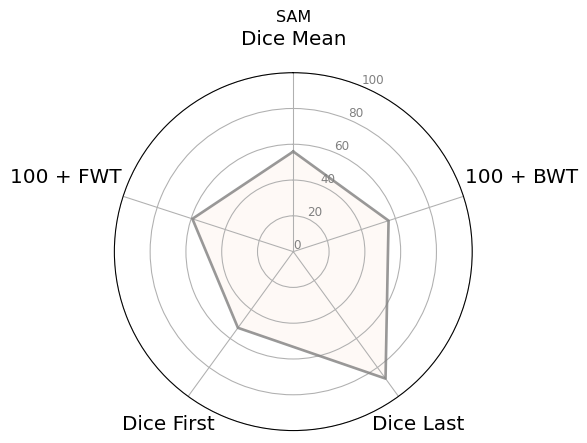

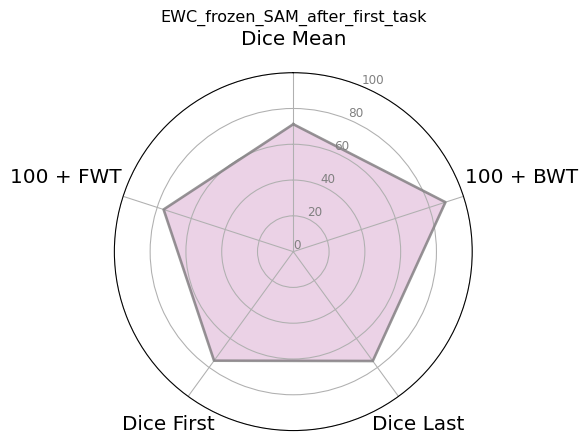

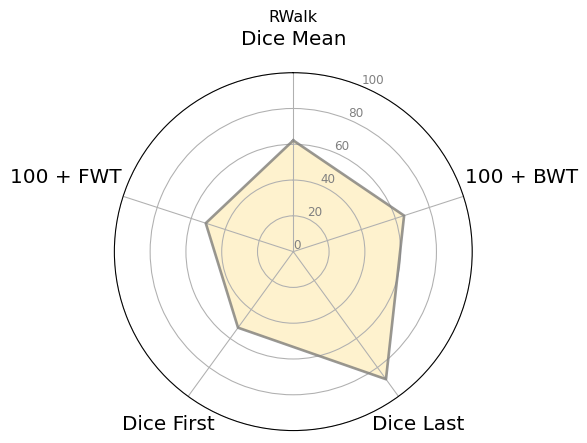

In [13]:
# ------- PART 2: Apply the function to all individuals
colors = {'SAM': '#fae5d6', 'RWalk':'#fec10b', 'EWC':'#9e1e83'}#, 'Rehearsal': '#26a671'

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_evaluation/plots/hip_spiders_{title}.pdf', bbox_inches='tight')

In [14]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'$\mathcal{T}_{1}$': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'$\mathcal{T}_{2}$': [np.mean(list(Dice_2[m].values()))*100 for m in methods],
'$\mathcal{T}_{3}$': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.xaxis.set_tick_params(pad=15)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    # plt.xticks(angles[:-1], categories, color='black', size=15)
    plt.xticks(angles[:-1], categories, color='black', size=31)
    
    # Draw ylabels
    # ax.set_rlabel_position(0)
    # plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=11)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=15)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

2024-01-26 11:21:07,357 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,362 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,364 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,412 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,414 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,416 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,441 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,444 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,447 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,483 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,485 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,487 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,533 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,535 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,537 - Substituting symbol T 

2024-01-26 11:21:07,663 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,666 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,668 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,694 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,697 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,699 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,759 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,761 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,763 - Substituting symbol T from STIXNonUnicode


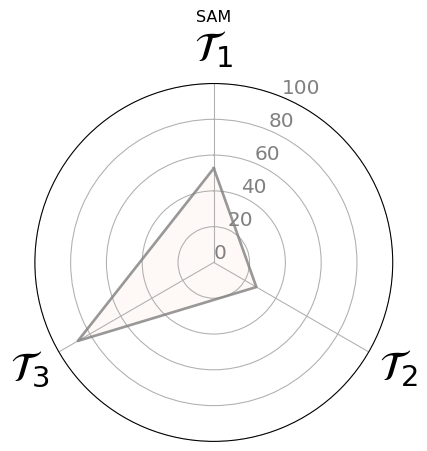

2024-01-26 11:21:07,829 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,832 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,833 - Substituting symbol T from STIXNonUnicode


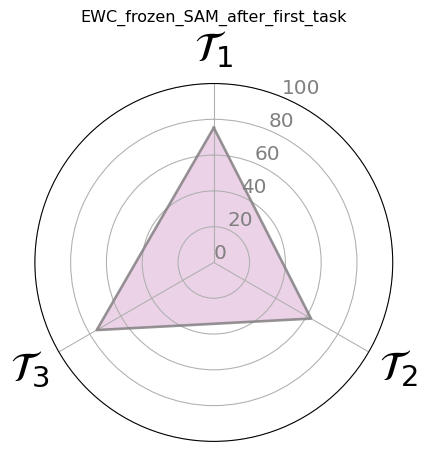

2024-01-26 11:21:07,901 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,903 - Substituting symbol T from STIXNonUnicode
2024-01-26 11:21:07,905 - Substituting symbol T from STIXNonUnicode


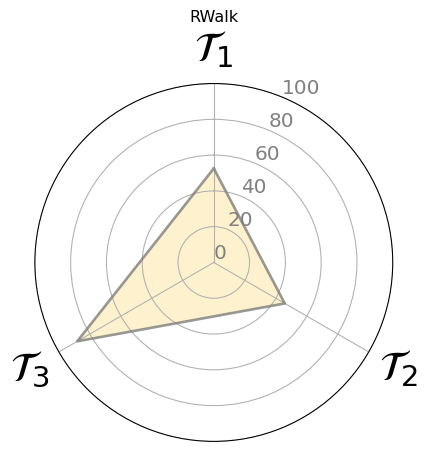

In [15]:
# ------- PART 2: Apply the function to all individuals
colors = {'SAM': '#fae5d6', 'RWalk':'#fec10b', 'EWC':'#9e1e83'}#, 'Rehearsal': '#26a671'

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/MIDL_2024/MIDL_2024_evaluation/plots/hip_spiders_{title}_dices.pdf', bbox_inches='tight')